In [1]:
from create_dataset import ImageNetSubset

In [2]:
full_dataset = ImageNetSubset()

In [3]:
import torch
import torchvision
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42),
)

batch_size = 4

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('coffee-mug', 'notebook', 'remote-control', 'soup-bowl', 'teapot', 'wooden-spoon', 'computer-keyboard', 'mouse', 'binder', 'toilet-tissue')

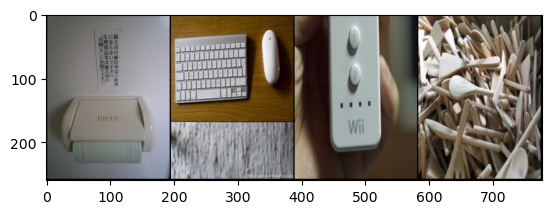

toilet-tissue mouse remote-control wooden-spoon


In [4]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, input_size=(32, 32)):
        super().__init__()

        # Convs wie im Original (nur in_channels variabel)
        self.conv1 = nn.Conv2d(in_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Hier bestimmen wir automatisch die Größe für fc1:
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, *input_size)  # (1, C, H, W)
            x = self.pool(F.relu(self.conv1(dummy)))
            x = self.pool(F.relu(self.conv2(x)))
            n_features = x.view(1, -1).size(1)  # Anzahl Features nach Conv+Pool

        self.fc1 = nn.Linear(n_features, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net(in_channels=3, num_classes=10, input_size=(256, 192))

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.281
[2,  2000] loss: 2.119
Finished Training


In [8]:
PATH = './image_net.pth'
torch.save(net.state_dict(), PATH)